In [2]:
import gc
import sys
import os
import warnings
from tqdm import tqdm
import seaborn as sns    

sys.path.append(os.path.abspath("modules/"))
sys.path.append(os.path.abspath("fe_modules/"))
sys.path.append(os.path.abspath("seq2seq_modules/"))

os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import time
import polars as pl
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [4]:
import importlib

import modules
import fe_modules

importlib.reload(modules)
importlib.reload(fe_modules)

from modules.memory_utils import pandas_reduce_mem_usage, pandas_string_to_cat, my_reset
from fe_modules.text_manipulation import get_domain
from fe_modules.datetime_features import get_timestamp, get_relative_time, part_of_day_to_hour, add_hour_to_date
from fe_modules.preprocessing import clean_os_type

# Load data

In [5]:
LOCAL_DATA_PATH = './data/'
SPLIT_SEED = 42

In [6]:
df = pandas_reduce_mem_usage( 
        pd.read_parquet(
            f'{LOCAL_DATA_PATH}competition_data_final_pqt/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet'
    ))
df

Memory usage of dataframe is 2988.16 MB


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.18it/s]

Memory usage after optimization is: 2521.26 MB
Decreased by 15.6%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098
...,...,...,...,...,...,...,...,...,...,...,...,...
32638704,Самарская область,Самара,Xiaomi,Redmi Note 8,sun9-17.userapi.com,smartphone,Android,NaN,2022-04-21,morning,1,162531
32638705,Самарская область,Самара,Xiaomi,Redmi Note 8,sun9-27.userapi.com,smartphone,Android,NaN,2022-04-11,morning,1,162531
32638706,Самарская область,Самара,Xiaomi,Redmi Note 8,sun9-85.userapi.com,smartphone,Android,NaN,2022-04-01,evening,1,162531
32638707,Самарская область,Самара,Xiaomi,Redmi Note 8,sun9-85.userapi.com,smartphone,Android,NaN,2022-04-04,day,2,162531


In [29]:
copy_df = pd.DataFrame({'site_name': df['url_host'].unique()})

In [30]:
copy_df

,site_name
0,ad.adriver.ru
1,apple.com
2,avatars.mds.yandex.net
3,googleads.g.doubleclick.net
4,i.ytimg.com
...,...
199678,poliglot1.com
199679,reservemaster.ru
199680,uploadhive.com
199681,kuzma2012.livejournal.com


In [31]:
df["url_host"].value_counts().info()

<class 'pandas.core.series.Series'>
Index: 199683 entries, googleads.g.doubleclick.net to stroitelnye-materialy-v-kurske.ru
Series name: url_host
Non-Null Count   Dtype
--------------   -----
199683 non-null  int64
dtypes: int64(1)
memory usage: 3.0+ MB


In [52]:
copy_df = pd.DataFrame(df["url_host"].value_counts()).rename(columns={'url_host':'counts'})
copy_df["url_host"] = copy_df.index
copy_df = copy_df.sort_values(by='counts', ascending=False)
x = list(range(len(copy_df['counts_'+row_name])))
y = list(copy_df['counts_'+row_name].apply(lambda y: y / copy_df['counts_'+row_name].sum()))
summ = 0
for i in  tqdm(range(len(y))):
    summ += y[i]
    y[i] = summ
sns.relplot(x=x, y=y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 514/514 [00:00<00:00, 514650.81it/s]


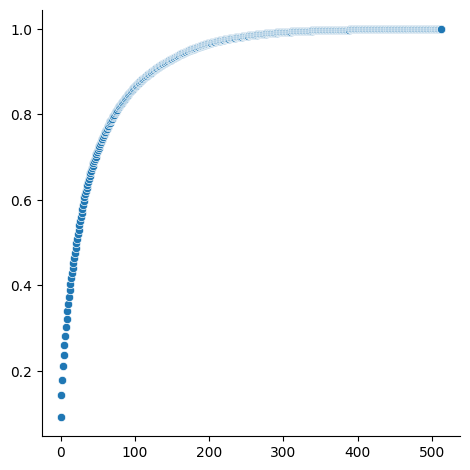

In [18]:
df = popularity("cpe_model_name",df)

In [24]:
(df['cpe_model_name'].unique().shape[0]-370)/df['cpe_model_name'].unique().shape[0], 370/df['cpe_model_name'].unique().shape[0]

(0.2801556420233463, 0.7198443579766537)

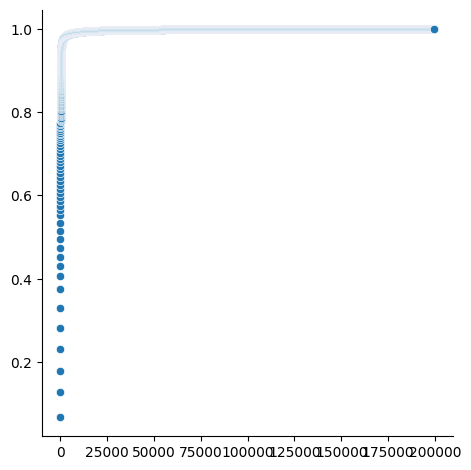

In [62]:
y[10000]

0.9926991479560867

In [65]:
copy_df[:10_000]["url_host"].to_csv("top_10k_urls.csv", index=False)

In [46]:
df = pd.read_excel('models_ex.xlsx')
df = df.rename(columns={'Unnamed: 2':'price'})
df['price'] = df['price'].astype(int)

In [48]:
df.to_csv('phones_with_prices.csv')

In [52]:
df = pd.read_csv('phones_with_prices.csv', usecols=['cpe_manufacturer_name','cpe_model_name','price'])
df.head()

,cpe_manufacturer_name,cpe_model_name,price
0,LG,K10 LTE Dual,3995
1,Samsung,Galaxy Note 20,54990
2,Samsung,Galaxy S22 Ultra,89990
3,Xiaomi,Mi 11 Lite 5G,37990
4,Xiaomi,Xiaomi 11T Pro,43999


In [ ]:
def map_cities(df, cities_path):
    cities = pandas_reduce_mem_usage(
    pd.read_csv(cities_path, usecols=["region", 
                                           "city_type", 
                                           "city", 
                                           "capital_marker",
                                           "geo_lat",
                                           "geo_lon",
                                           'timezone',
                                           'population']).rename(
                                columns={
                                    "city": "city_name", 
                                    "geo_lat": "lat",
                                    "geo_lon": "lon"
                                }))
    df = df.merge(cities[["city_name", "lat", "lon", "capital_marker",'timezone']], on="city_name", how="left")
    return df

def popularity(row_name,df):
    copy_df = pd.DataFrame(df[row_name].value_counts()).rename(columns={row_name:'counts_'+row_name})
    copy_df[row_name] = copy_df.index
    copy_df = copy_df.sort_values(by='counts_'+row_name, ascending=False)
    df = df.merge(copy_df[['counts_'+row_name]], on=row_name, how="left")
    return copy_df

def map_prices(df, price_path):
    price = pd.read_csv('phones_with_prices.csv', usecols=['cpe_manufacturer_name','cpe_model_name','price'])
    df = df.merge(price[['price']], on="cpe_model_name", how="left")
    return df

In [6]:
df

,url_host,title,uri,description,site_name,keywords,text,vpn_only
0,http://googleads.g.doubleclick.net,NaN,NaN,NaN,NaN,NaN,NaN,0
1,http://yandex.ru,Яндекс,NaN,Найдётся всё,NaN,NaN,"Ой! Подтвердите, что запросы отправляли вы, а ...",0
2,http://i.ytimg.com,NaN,NaN,NaN,NaN,NaN,NaN,0
3,http://vk.com,Мобильная версия ВКонтакте | ВКонтакте,NaN,ВКонтакте – универсальное средство для общения...,NaN,NaN,Мобильная версия ВКонтакте | ВКонтакте Установ...,0
4,http://avatars.mds.yandex.net,NaN,NaN,NaN,NaN,NaN,410 Gone 410 Gone nginx,0
...,...,...,...,...,...,...,...,...
9995,http://tolstoy-lit.ru,NaN,NaN,NaN,NaN,NaN,403 Forbidden Forbidden You don't have permiss...,1
9996,http://neprizyvnoi.ru,Все об армии и призыве: информационная помощь ...,NaN,NaN,NaN,NaN,Все об армии и призыве: информационная помощь ...,0
9997,http://wik-end.com,Новости Твери и Тверской области - информацион...,https://wik-end.com,Информационный портал Weekend-Тверь - всегда с...,NaN,NaN,Новости Твери и Тверской области - информацион...,0
9998,http://probeg.org,NaN,NaN,NaN,NaN,NaN,NaN,0


In [55]:
df = pandas_reduce_mem_usage( pd.read_csv('sites_out_copy.csv', sep=';', index_col=0))
df['vpn_only']=df['text'].str.contains('403 Forbidden | Akado').fillna(False).astype(int)
df = df[df['url_host'].str.contains('userapi')==0]
df = df[(df['vpn_only']==1) | (df['text'].isnull())].reset_index(drop= True)
df = df.drop(['vpn_only', 'uri','site_name','keywords'], axis=1)

Memory usage of dataframe is 0.61 MB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]

Memory usage after optimization is: 0.61 MB
Decreased by 0.0%


In [56]:
df

,url_host,title,description,text
0,http://googleads.g.doubleclick.net,NaN,NaN,NaN
1,http://i.ytimg.com,NaN,NaN,NaN
2,http://tpc.googlesyndication.com,NaN,NaN,NaN
3,http://instagram.com,Akado,NaN,﻿ Akado Подключение ИНТЕРАКТИВНОГО ТВ Отправит...
4,http://zen.yandex.ru,NaN,NaN,NaN
...,...,...,...,...
2781,http://utyug.info,Утренний Юг - Главная страница,NaN,NaN
2782,http://lords.cam,Akado,NaN,﻿ Akado Подключение ИНТЕРАКТИВНОГО ТВ Отправит...
2783,http://tolstoy-lit.ru,NaN,NaN,403 Forbidden Forbidden You don't have permiss...
2784,http://probeg.org,NaN,NaN,NaN


In [57]:
df.to_csv('sites_out_vpn.csv')

In [23]:
df = df[(df['description'].isna()==0) | (df['text'].isna()==0)]

In [25]:
df[['description','text']]

,description,text
1,Найдётся всё,"Ой! Подтвердите, что запросы отправляли вы, а ..."
3,ВКонтакте – универсальное средство для общения...,Мобильная версия ВКонтакте | ВКонтакте Установ...
4,NaN,410 Gone 410 Gone nginx
5,NaN,Рекламная платформа myTarget — Сервис таргетир...
6,Найдётся всё,"Ой! Подтвердите, что запросы отправляли вы, а ..."
...,...,...
9317,NaN,Парк «Сокольники»
9318,"«Стерлитамакский рабочий», \n г. Стерлитамак",Стерлитамакский рабочий -10 °С Облачно Подписа...
9319,NaN,info-effect.ru — Инструкции для интернет польз...
9320,NaN,Все об армии и призыве: информационная помощь ...


In [43]:
def text_or_desc(row):
    if pd.isnull(row['description']):
        return row['text']
    return row['description']

df['tod']=df[['description','text']].apply(lambda x: text_or_desc(x),axis=1)
df = df.drop(['description', 'text'], axis=1)

In [45]:
df.to_csv('sites_out_only_text.csv')